In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

/Users/zoey/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/zoey/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
# mean expression
data = pd.read_csv("mean_expression.csv")
labels = pd.read_csv("metadata.csv")

data = data.merge(labels[['Donor ID', 'Last CASI Score']], on='Donor ID', how='left')

In [4]:
print(data.columns)
print(data["cell_type"].unique())

Index(['Unnamed: 0', 'Donor ID', 'cell_type', 'RSRC1', 'RNGTT', 'LIMS1',
       'MAPK1', 'KIZ', 'SACS', 'RNF180',
       ...
       'IQCJ-SCHIP1', 'SGCZ', 'CNTN5', 'RALYL', 'DPP10', 'ADARB2', 'ROBO2',
       'KCNIP4', 'ERBB4', 'Last CASI Score'],
      dtype='object', length=2004)
[0 1 2 3]


In [14]:
data_type1 = data[data['cell_type'] == 0]
data_type2 = data[data['cell_type'] == 1]
data_type3 = data[data['cell_type'] == 2]
data_type4 = data[data['cell_type'] == 3]
print(data_type1.shape, data_type2.shape, data_type3.shape, data_type4.shape)

(69, 2004) (69, 2004) (69, 2004) (69, 2004)


# Mean Expression of 4 Cell Types Prediction

Starting training for 50 epochs...
Epoch 10/50 - Train MSE: 85775826746930162435096576.0000 - Test MSE: 120284123288025901909934080.0000
Epoch 20/50 - Train MSE: 77433037290694956512444416.0000 - Test MSE: 73256853640953945632276480.0000
Epoch 30/50 - Train MSE: 30153499044031462687899648.0000 - Test MSE: 19382381370830936912953344.0000
Epoch 40/50 - Train MSE: 74205171704471158955966464.0000 - Test MSE: 64042205769035851004641280.0000
Epoch 50/50 - Train MSE: 80466615946224912035741696.0000 - Test MSE: 62299194907422192467705856.0000
Training finished.


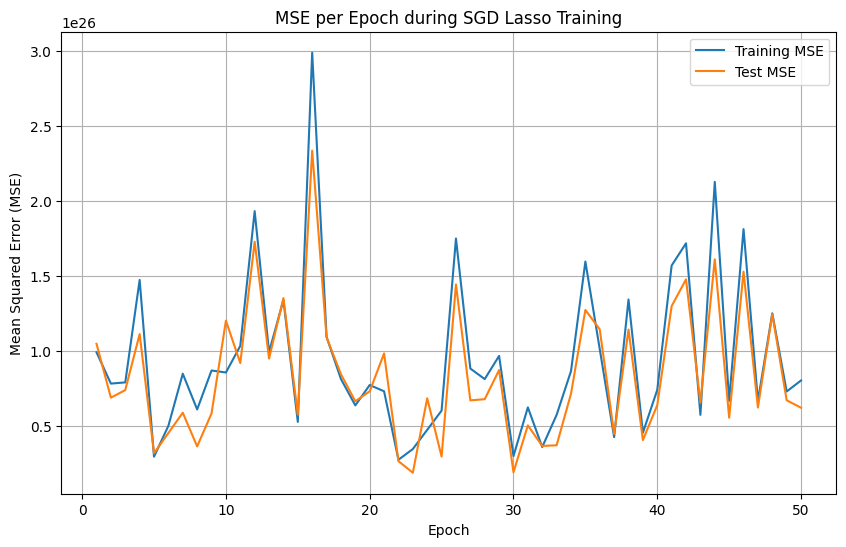


Final Coefficients from SGDRegressor (Lasso):
[-2.42941385e+10 -5.90864489e+10 -6.94634387e+09 ... -4.87525544e+10
 -4.65808266e+10 -9.86897956e+10]

Number of features used: 2000 out of 2000


In [9]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression


# Extract features and labels from your data
X = data.iloc[:,3:-1].values                       # numpy array of features
y = data.iloc[:,-1].values       # pandas Series of labels (with 4 classes)


# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use transform only on test data

n_epochs = 50  # How many passes over the data
alpha_value = 0.01 # Regularization strength (tune this!)
initial_learning_rate = 0.01 # Starting learning rate (tune this!)

sgd_lasso = SGDRegressor(
    loss='squared_error',
    penalty='l1',
    alpha=alpha_value,
    max_iter=1,         # Process data roughly once per partial_fit call
    tol=None,           # Don't stop early within one partial_fit call
    learning_rate='constant', # Or 'optimal', 'invscaling', 'adaptive'
    eta0=initial_learning_rate,
    warm_start=True,    # Reuse weights from previous iteration
    random_state=42     # For reproducibility
)

# 5. Training Loop to track MSE per epoch
train_mse_history = []
test_mse_history = []

print(f"Starting training for {n_epochs} epochs...")
for epoch in range(n_epochs):
    # Train for one "epoch"
    # For large datasets, you might feed data in batches here
    sgd_lasso.partial_fit(X_train_scaled, y_train)

    # Calculate MSE on training data for this epoch
    y_train_pred = sgd_lasso.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mse_history.append(train_mse)

    # Calculate MSE on test data for this epoch (more realistic performance)
    y_test_pred = sgd_lasso.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mse_history.append(test_mse)

    if (epoch + 1) % 10 == 0: # Print progress periodically
         print(f"Epoch {epoch+1}/{n_epochs} - Train MSE: {train_mse:.4f} - Test MSE: {test_mse:.4f}")

print("Training finished.")

# 6. Plot MSE History
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_mse_history, label='Training MSE')
plt.plot(range(1, n_epochs + 1), test_mse_history, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE per Epoch during SGD Lasso Training')
plt.legend()
plt.grid(True)
plt.show()

# You can inspect the final coefficients
print("\nFinal Coefficients from SGDRegressor (Lasso):")
print(sgd_lasso.coef_)
print(f"\nNumber of features used: {np.sum(sgd_lasso.coef_ != 0)} out of {X.shape[1]}")


Starting training for 50 epochs...
Epoch 10/50 - Train MSE: 197944880231096035840098304.0000 - Test MSE: 43209781922648334262075392.0000
Epoch 20/50 - Train MSE: 268424785032043713515225088.0000 - Test MSE: 172856483267155429502746624.0000
Epoch 30/50 - Train MSE: 124922535386399341537132544.0000 - Test MSE: 84094999993185405417553920.0000
Epoch 40/50 - Train MSE: 84535810255129489631608832.0000 - Test MSE: 112047828791445341532585984.0000
Epoch 50/50 - Train MSE: 100111031373071306025074688.0000 - Test MSE: 79746871616384646799949824.0000
Training finished.


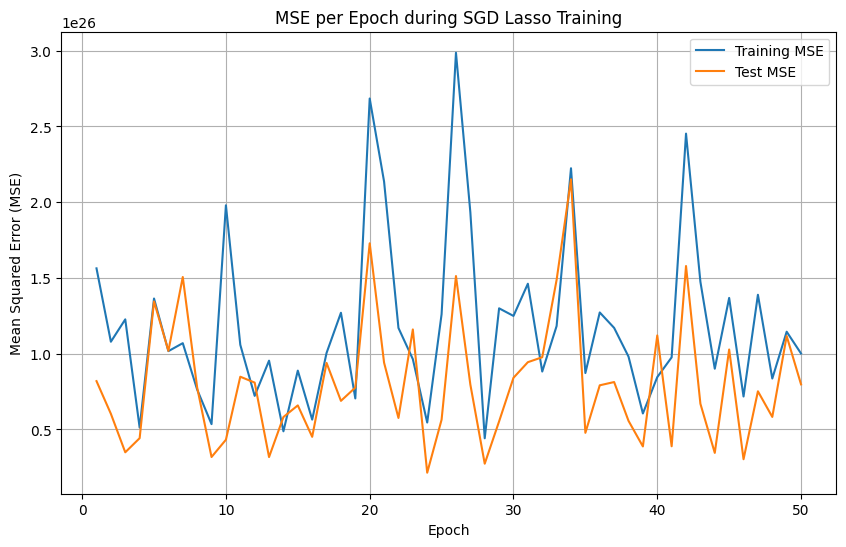


Final Coefficients from SGDRegressor (Lasso):
[ 5.69438687e+10  4.84151671e+10 -1.21096115e+10 ... -5.90602603e+09
  1.38142174e+10  3.34773484e+09]

Number of features used: 1999 out of 1999


In [12]:

# Extract features and labels from your data
X = data_type1.iloc[:,3:-1].values                       # numpy array of features
y = data_type1.iloc[:,-1].values       # pandas Series of labels (with 4 classes)


# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use transform only on test data

n_epochs = 50  # How many passes over the data
alpha_value = 0.01 # Regularization strength (tune this!)
initial_learning_rate = 0.01 # Starting learning rate (tune this!)

sgd_lasso = SGDRegressor(
    loss='squared_error',
    penalty='l1',
    alpha=alpha_value,
    max_iter=1,         # Process data roughly once per partial_fit call
    tol=None,           # Don't stop early within one partial_fit call
    learning_rate='constant', # Or 'optimal', 'invscaling', 'adaptive'
    eta0=initial_learning_rate,
    warm_start=True,    # Reuse weights from previous iteration
    random_state=42     # For reproducibility
)

# 5. Training Loop to track MSE per epoch
train_mse_history = []
test_mse_history = []

print(f"Starting training for {n_epochs} epochs...")
for epoch in range(n_epochs):
    # Train for one "epoch"
    # For large datasets, you might feed data in batches here
    sgd_lasso.partial_fit(X_train_scaled, y_train)

    # Calculate MSE on training data for this epoch
    y_train_pred = sgd_lasso.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mse_history.append(train_mse)

    # Calculate MSE on test data for this epoch (more realistic performance)
    y_test_pred = sgd_lasso.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mse_history.append(test_mse)

    if (epoch + 1) % 10 == 0: # Print progress periodically
         print(f"Epoch {epoch+1}/{n_epochs} - Train MSE: {train_mse:.4f} - Test MSE: {test_mse:.4f}")

print("Training finished.")

# 6. Plot MSE History
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_mse_history, label='Training MSE')
plt.plot(range(1, n_epochs + 1), test_mse_history, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE per Epoch during SGD Lasso Training')
plt.legend()
plt.grid(True)
plt.show()

# You can inspect the final coefficients
print("\nFinal Coefficients from SGDRegressor (Lasso):")
print(sgd_lasso.coef_)
print(f"\nNumber of features used: {np.sum(sgd_lasso.coef_ != 0)} out of {X.shape[1]}")


Shape of X: (69, 2000)
Number of feature names extracted: 2000
Starting training for 100 epochs...
Epoch 10/100 - Train MSE: 140075.4519 - Test MSE: 256978.7691
Epoch 20/100 - Train MSE: 109378.5082 - Test MSE: 196516.2395
Epoch 30/100 - Train MSE: 96014.2440 - Test MSE: 172958.3415
Epoch 40/100 - Train MSE: 88084.5879 - Test MSE: 158856.2999
Epoch 50/100 - Train MSE: 82499.1419 - Test MSE: 149044.8608
Epoch 60/100 - Train MSE: 78195.0933 - Test MSE: 141516.1932
Epoch 70/100 - Train MSE: 74768.5379 - Test MSE: 135495.3847
Epoch 80/100 - Train MSE: 71939.7631 - Test MSE: 130671.2159
Epoch 90/100 - Train MSE: 69523.5828 - Test MSE: 126593.4178
Epoch 100/100 - Train MSE: 67443.4351 - Test MSE: 123025.0413
Training finished.


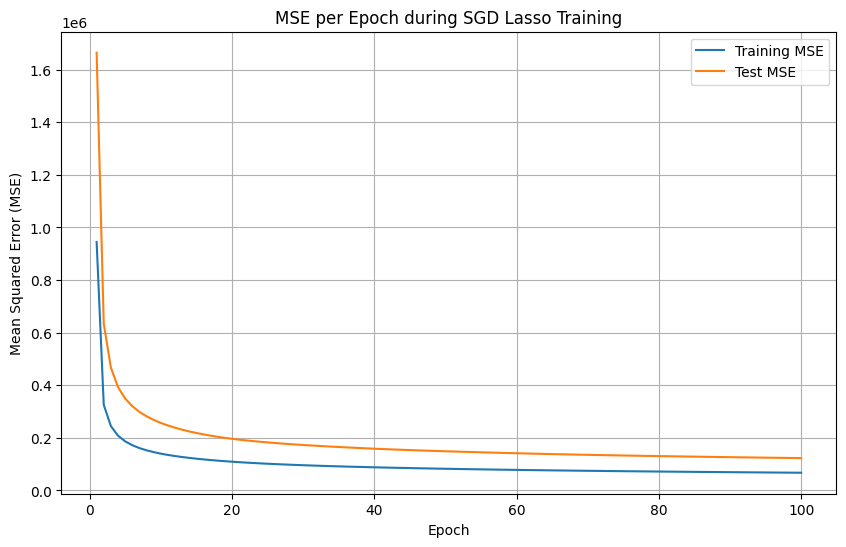


Saving feature weights to feature_weights1.txt...
Finished saving to feature_weights1.txt

Saving feature weights to feature_weights1.csv...
Finished saving to feature_weights1.csv

Final Coefficients from SGDRegressor (Lasso):
First 10 coefficients:
  RSRC1: 0.000000
  RNGTT: 0.000000
  LIMS1: -1.548796
  MAPK1: 0.000000
  KIZ: 0.000000
  SACS: 0.000000
  RNF180: 0.000000
  TRA2A: 0.000000
  MRPS30-DT: 0.000000
  RAB3IP: 0.000000
...
Last 10 coefficients:
  RBFOX1: 1.898326
  IQCJ-SCHIP1: 0.983895
  SGCZ: 0.000000
  CNTN5: 0.000000
  RALYL: 0.000000
  DPP10: 0.000000
  ADARB2: 0.000000
  ROBO2: 0.000000
  KCNIP4: 0.000000
  ERBB4: 0.000000

Number of non-zero features used: 375 out of 2000


In [38]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression


feature_columns = data_type1.columns[3:-1] # Get the names of the feature columns
X = data_type1[feature_columns].values    # Use column names for clarity & safety
y = data_type1.iloc[:,-1].values          # Label is the last column

print(f"Shape of X: {X.shape}")
print(f"Number of feature names extracted: {len(feature_columns)}")
if X.shape[1] != len(feature_columns):
    raise ValueError("Mismatch between number of features in X and number of feature names!")

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use transform only on test data

# 4. Define the model
n_epochs = 100
alpha_value = 100
initial_learning_rate = 1

sgd_lasso = SGDRegressor(
    loss='squared_error',
    penalty='l1',          # Lasso penalty
    alpha=alpha_value,     # Regularization strength
    max_iter=1,            # Process data roughly once per partial_fit call
    tol=None,              # Don't stop early within one partial_fit call
    learning_rate='optimal',
    eta0=initial_learning_rate,
    warm_start=True,       # Reuse weights from previous iteration
    random_state=42
)

# 5. Training Loop
train_mse_history = []
test_mse_history = []

print(f"Starting training for {n_epochs} epochs...")
for epoch in range(n_epochs):
    sgd_lasso.partial_fit(X_train_scaled, y_train) # No need to loop through y classes for regression

    y_train_pred = sgd_lasso.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mse_history.append(train_mse)

    y_test_pred = sgd_lasso.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mse_history.append(test_mse)

    if (epoch + 1) % 10 == 0:
         print(f"Epoch {epoch+1}/{n_epochs} - Train MSE: {train_mse:.4f} - Test MSE: {test_mse:.4f}")

print("Training finished.")

# 6. Plot MSE History (Optional but good practice)
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_mse_history, label='Training MSE')
plt.plot(range(1, n_epochs + 1), test_mse_history, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE per Epoch during SGD Lasso Training')
plt.legend()
plt.grid(True)
plt.show()

# 7. Get Final Coefficients and Feature Names
final_coefficients = sgd_lasso.coef_

# Ensure the number of coefficients matches the number of feature names
if len(final_coefficients) != len(feature_columns):
     raise ValueError(f"Mismatch! Number of coefficients ({len(final_coefficients)}) "
                      f"does not match number of feature names ({len(feature_columns)}). "
                      "Check feature extraction logic.")

# 8. Save Weights with Feature Names

# ---- Option 1: Save as a simple text file ----
output_filename_txt = "feature_weights1.txt"
print(f"\nSaving feature weights to {output_filename_txt}...")
with open(output_filename_txt, "w") as f:
    f.write("Feature_Name\tWeight\n") # Header line
    for name, weight in zip(feature_columns, final_coefficients):
        f.write(f"{name}\t{weight:.8f}\n") # Use tab separation, format weight
print(f"Finished saving to {output_filename_txt}")

# ---- Option 2: Save as a CSV file (often more convenient) ----
output_filename_csv = "feature_weights1.csv"
print(f"\nSaving feature weights to {output_filename_csv}...")
weights_df = pd.DataFrame({
    'Feature_Name': feature_columns,
    'Weight': final_coefficients
})
# Optional: Sort by absolute weight magnitude to see most important features
# weights_df['Abs_Weight'] = weights_df['Weight'].abs()
# weights_df = weights_df.sort_values(by='Abs_Weight', ascending=False).drop(columns=['Abs_Weight'])

weights_df.to_csv(output_filename_csv, index=False) # index=False prevents writing row numbers
print(f"Finished saving to {output_filename_csv}")


# 9. Inspect Final Coefficients (as before)
print("\nFinal Coefficients from SGDRegressor (Lasso):")
# Print only the first few and last few if there are many
if len(final_coefficients) > 20:
    print("First 10 coefficients:")
    for name, weight in zip(feature_columns[:10], final_coefficients[:10]):
        print(f"  {name}: {weight:.6f}")
    print("...")
    print("Last 10 coefficients:")
    for name, weight in zip(feature_columns[-10:], final_coefficients[-10:]):
        print(f"  {name}: {weight:.6f}")
else:
     for name, weight in zip(feature_columns, final_coefficients):
        print(f"  {name}: {weight:.6f}")


print(f"\nNumber of non-zero features used: {np.sum(final_coefficients != 0)} out of {X.shape[1]}")


In [55]:
# filter the gene that are most correlated to the label
# take the intersection of 4 cell types non-zero weight genes
#weight1 = pd.read_csv("feature_weights1.csv")
weight2 = pd.read_csv("feature_weights2.csv")
weight3 = pd.read_csv("feature_weights3.csv")
weight4 = pd.read_csv("feature_weights4.csv")

#mask = (weight1['Weight'] != 0.0) & (weight1['Weight'].notna()) 
#nl1 = weight1.loc[mask, 'Feature_Name'].tolist()
mask = (weight2['Weight'] != 0.0) & (weight2['Weight'].notna()) 
nl2 = weight2.loc[mask, 'Feature_Name'].tolist()
mask = (weight3['Weight'] != 0.0) & (weight3['Weight'].notna()) 
nl3 = weight3.loc[mask, 'Feature_Name'].tolist()
mask = (weight4['Weight'] != 0.0) & (weight4['Weight'].notna()) 
nl4 = weight4.loc[mask, 'Feature_Name'].tolist()

nl = []
for name in nl2: 
    if name in nl3 and name in nl4:
        nl.append(name)
print(len(nl))
nl.to_csv("commonGene.csv")

15


AttributeError: 'list' object has no attribute 'to_csv'

### Cluster 0: Astrocytes
### Cluster 1: Excitatory neurons
### Cluster 2: Inhibitory neurons
### Cluster 3: Oligodendrocytes

In [57]:
# filter the genes that are important
# choose cell type 2,3,4 as our focus
data_common = pd.concat([data.iloc[:,:3],data.iloc[:,3:-1].filter(items=nl, axis=1), data.iloc[:,-1]], axis=1)
data_common.to_csv("common_expression.csv")

Starting training for 500 epochs...
Epoch 10/500 - Train MSE: 7093.3518 - Test MSE: 8163.0390
Epoch 20/500 - Train MSE: 6356.0319 - Test MSE: 7300.0769
Epoch 30/500 - Train MSE: 5965.5013 - Test MSE: 6844.1777
Epoch 40/500 - Train MSE: 5705.1521 - Test MSE: 6541.4992
Epoch 50/500 - Train MSE: 5512.2746 - Test MSE: 6318.5641
Epoch 60/500 - Train MSE: 5360.2557 - Test MSE: 6143.6032
Epoch 70/500 - Train MSE: 5235.4753 - Test MSE: 6000.4672
Epoch 80/500 - Train MSE: 5133.0036 - Test MSE: 5877.0381
Epoch 90/500 - Train MSE: 5046.2800 - Test MSE: 5769.1957
Epoch 100/500 - Train MSE: 4970.1369 - Test MSE: 5674.8710
Epoch 110/500 - Train MSE: 4902.3919 - Test MSE: 5591.2304
Epoch 120/500 - Train MSE: 4841.4642 - Test MSE: 5516.2301
Epoch 130/500 - Train MSE: 4786.1737 - Test MSE: 5448.3507
Epoch 140/500 - Train MSE: 4735.6174 - Test MSE: 5386.4332
Epoch 150/500 - Train MSE: 4689.0894 - Test MSE: 5329.5749
Epoch 160/500 - Train MSE: 4645.8310 - Test MSE: 5276.9649
Epoch 170/500 - Train MSE: 46

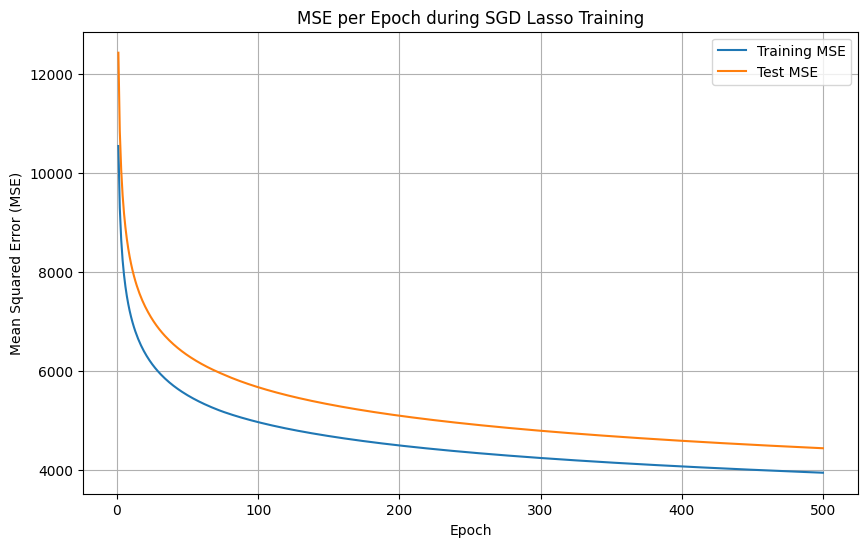

Number of non-zero weights: 8 out of 15


In [65]:
feature_columns = data_common.columns[3:-1]
X = data_common.iloc[:,3:-1].values    # Use column names for clarity & safety
y = data_common.iloc[:,-1].values          # Label is the last column

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use transform only on test data

# 4. Define the model
n_epochs = 500
alpha_value = 10
initial_learning_rate = 1

sgd_lasso = SGDRegressor(
    loss='squared_error',
    penalty='l1',          # Lasso penalty
    alpha=alpha_value,     # Regularization strength
    max_iter=1,            # Process data roughly once per partial_fit call
    tol=None,              # Don't stop early within one partial_fit call
    learning_rate='optimal',
    eta0=initial_learning_rate,
    warm_start=True,       # Reuse weights from previous iteration
    random_state=42
)

# 5. Training Loop
train_mse_history = []
test_mse_history = []

print(f"Starting training for {n_epochs} epochs...")
for epoch in range(n_epochs):
    sgd_lasso.partial_fit(X_train_scaled, y_train) # No need to loop through y classes for regression

    y_train_pred = sgd_lasso.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mse_history.append(train_mse)

    y_test_pred = sgd_lasso.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mse_history.append(test_mse)

    if (epoch + 1) % 10 == 0:
         print(f"Epoch {epoch+1}/{n_epochs} - Train MSE: {train_mse:.4f} - Test MSE: {test_mse:.4f}")

print("Training finished.")

# 6. Plot MSE History (Optional but good practice)
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_mse_history, label='Training MSE')
plt.plot(range(1, n_epochs + 1), test_mse_history, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE per Epoch during SGD Lasso Training')
plt.legend()
plt.grid(True)
plt.show()
non_zero_count = np.sum(sgd_lasso.coef_ != 0)
print(f"Number of non-zero weights: {non_zero_count} out of {len(sgd_lasso.coef_)}")

In [66]:
final_weights = sgd_lasso.coef_
df = pd.DataFrame({"Gene":feature_columns, "weights": final_weights})
df.to_csv("weights15gene.csv")